In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['seven.png']


In [2]:
from neon.backends import gen_backend

batch_size = 128

be = gen_backend(batch_size=batch_size)

DISPLAY:neon:mklEngine.so not found


In [3]:
from neon.data import MNIST

mnist = MNIST()
train_set = mnist.train_iter
valid_set = mnist.valid_iter

DISPLAY:neon:Downloading file: ./mnist.pkl.gz


Download Progress |██████████████████████████████████████████████████| 

DISPLAY:neon:Download Complete


In [4]:
from neon.initializers import Gaussian

init_norm = Gaussian(loc=0.0, scale=0.01)

In [5]:
from neon.layers import Affine,Conv,Pooling,Dropout
from neon.transforms import Rectlin, Softmax

layers = []
layers.append(Conv(fshape=(5,5,32),padding={'pad_w':2,'pad_h':2},init=init_norm,activation=Rectlin()))
layers.append(Pooling(fshape=2,strides=2))
layers.append(Conv(fshape=(5,5,64),padding={'pad_w':2,'pad_h':2},init=init_norm,activation=Rectlin()))
layers.append(Pooling(fshape=2,strides=2))
layers.append(Affine(nout=100, init=init_norm,
                     activation=Rectlin()))
layers.append(Dropout(keep=0.5))
layers.append(Affine(nout=10, init=init_norm,
                     activation=Softmax()))

In [6]:
from neon.models import Model

mlp = Model(layers=layers)

In [7]:
from neon.layers import GeneralizedCost
from neon.transforms import CrossEntropyMulti

cost = GeneralizedCost(costfunc=CrossEntropyMulti())

In [8]:
from neon.optimizers import GradientDescentMomentum

optimizer = GradientDescentMomentum(0.15, momentum_coef=0.9)

In [9]:
from neon.callbacks.callbacks import Callbacks

callbacks = Callbacks(mlp, eval_set=valid_set)


In [10]:
mlp.fit(train_set, optimizer=optimizer, num_epochs=6, cost=cost,
        callbacks=callbacks)

/opt/conda/lib/python3.6/site-packages/neon/backends/nervanacpu.py:681: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  array_output[numpy_ind.tolist()] = 1


Epoch 0   [Train |████████████████████|  469/469  batches, 0.19 cost, 381.07s]
Epoch 1   [Train |████████████████████|  469/469  batches, 0.15 cost, 376.91s]
Epoch 2   [Train |████████████████████|  469/469  batches, 0.11 cost, 376.88s]
Epoch 3   [Train |████████████████████|  468/468  batches, 0.10 cost, 372.31s]
Epoch 4   [Train |████████████████████|  468/468  batches, 0.06 cost, 372.93s]
Epoch 5   [Train |████████████████████|  468/468  batches, 0.07 cost, 374.60s]


In [11]:
results = mlp.get_outputs(valid_set)

/opt/conda/lib/python3.6/site-packages/neon/backends/nervanacpu.py:681: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  array_output[numpy_ind.tolist()] = 1


In [12]:
from neon.transforms import Misclassification

# evaluate the model on test_set using the misclassification metric
error = mlp.eval(valid_set, metric=Misclassification())*100
print('Misclassification error = %.1f%%' % error)

/opt/conda/lib/python3.6/site-packages/neon/backends/nervanacpu.py:681: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  array_output[numpy_ind.tolist()] = 1


Misclassification error = 1.1%


In [13]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# scale to 28x28 pixels
img = Image.open("../input/seven.png")


img.thumbnail((28, 28))

digit = np.asarray(img, dtype=np.float32) #[:, :, 0]
print(digit.shape)
# reshape to a single feature vector
digit = digit.reshape(784, 1)
# store digit into a GPU tensor
x_new = be.zeros((28*28, batch_size), dtype=np.float32)
x_new[:, 0] = digit


(28, 28)


Model final layer was: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
The most probable guess is digit: 7


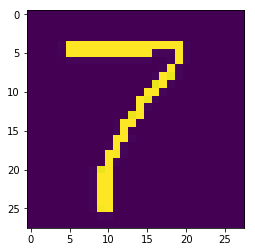

In [14]:
outputs = mlp.fprop(x_new)
outputs = outputs.get()[:, 0]

# examine the output of the model for this image
print("Model final layer was: {}".format(outputs))
print("The most probable guess is digit: {}".format(np.argmax(outputs)))
plt.figure(2)
plt.imshow(img)